In [79]:
import wandb
import pandas as pd
import numpy as np
from scipy.stats import binomtest

from matplotlib import pyplot as plt
%matplotlib inline

In [80]:
api = wandb.Api()

In [81]:
runs = api.runs(path="seas/vmcts")

In [82]:
df = pd.DataFrame()

groups = ["rollout-hyperparam-1"]

for run in runs:
    if run.group in groups:
        history = run.summary
        keys=["final/n_tokens"]
    
        run_dict = {}
        run_dict["id"] = run.id
        run_dict["group"] = run.group
        run_dict["discovery"] = run.config["discovery_factor"]
        run_dict["temp"] = run.config["model_arg_temp"]
        run_dict["topp"] = run.config["model_arg_topp"]
        run_dict["seed"] = run.config["seed"]

        if any([key not in history for key in keys]):
            continue
        for key in keys:
            run_dict[key] = history[key]

        run_df = pd.DataFrame(run_dict, index=[0])
        df = pd.concat([df, run_df])

In [83]:
df.head()

,id,group,discovery,temp,topp,seed,final/n_tokens
0,r14s2rgg,rollout-hyperparam-1,1.0,1.0,0.95,37,5188
0,2ryclgez,rollout-hyperparam-1,3.0,1.2,0.95,30,5034
0,ukyjemt2,rollout-hyperparam-1,10.0,0.8,0.95,30,5046
0,616ankzl,rollout-hyperparam-1,10.0,0.6,0.95,30,5179
0,lyfcra46,rollout-hyperparam-1,10.0,0.8,0.95,37,5447


In [84]:
len(df)

489

In [85]:
for temp in df.temp.unique():
    print(len(df[df["temp"] == temp]), temp)

123 1.0
123 1.2
121 0.8
122 0.6


In [86]:
def confidence_interval(successes, trials=100):
    ci = binomtest(successes, trials).proportion_ci(confidence_level=0.95, method="wilson")
    return ci.low, ci.high

In [87]:
def compute_pass_at_t_and_ci(df, t):
    passes = (df[f"final/n_tokens"] <= t).sum()
    total = len(df)
    pass_at_t = passes / total
    low, high = confidence_interval(passes, total)
    return pass_at_t, low, high

['0.6', '0.8', '1.0', '1.2']


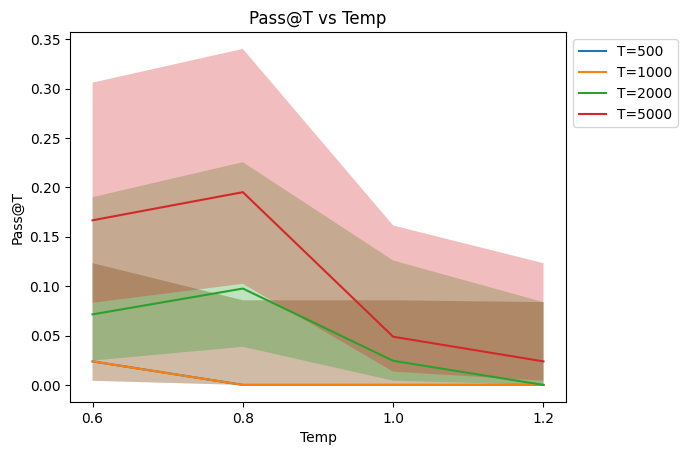

In [88]:
temps = sorted(df["temp"].unique())
print(temps)
discovery = '1.0'

for T in [500, 1000, 2000, 5000]:
    config_df = df[df["discovery"] == discovery]
    success_rates, lows, highs = [], [], []
    for temp in temps:
        config_df_2 = config_df[config_df["temp"] == temp]
        if config_df_2.empty:
            success_rate, low, high = np.nan, np.nan, np.nan
        else:
            success_rate, low, high = compute_pass_at_t_and_ci(config_df_2, T)
        success_rates.append(success_rate)
        lows.append(low)
        highs.append(high)

    plt.plot(temps, success_rates, label=f"T={T}")
    plt.fill_between(temps, lows, highs, alpha=0.3)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("Temp")
plt.ylabel(f"Pass@T")
plt.title(f"Pass@T vs Temp")
plt.show()

['1.0', '3.0', '10.0']


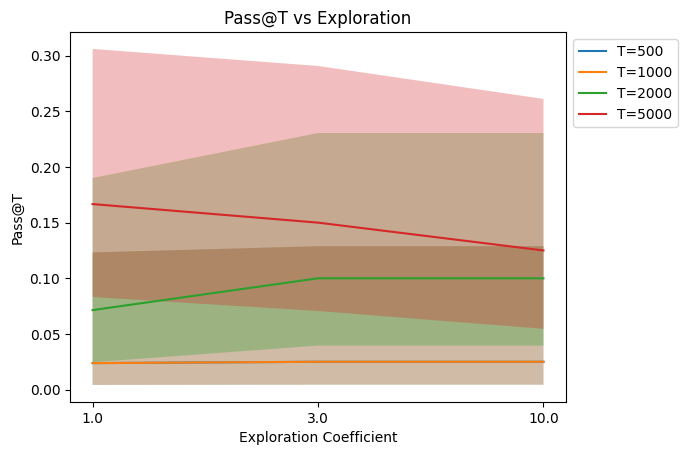

['1.0', '3.0', '10.0']


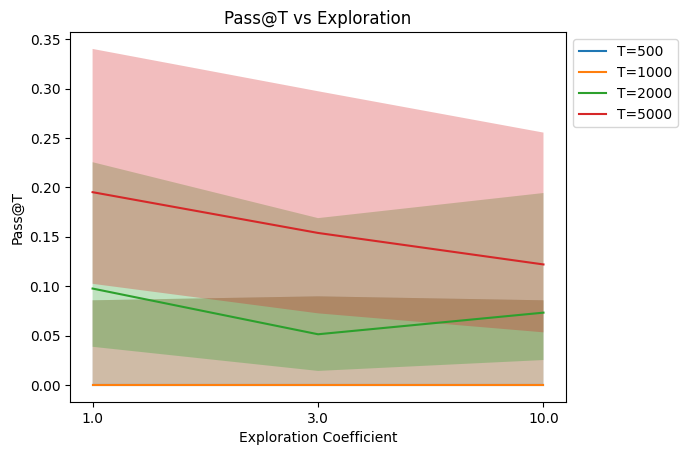

['1.0', '3.0', '10.0']


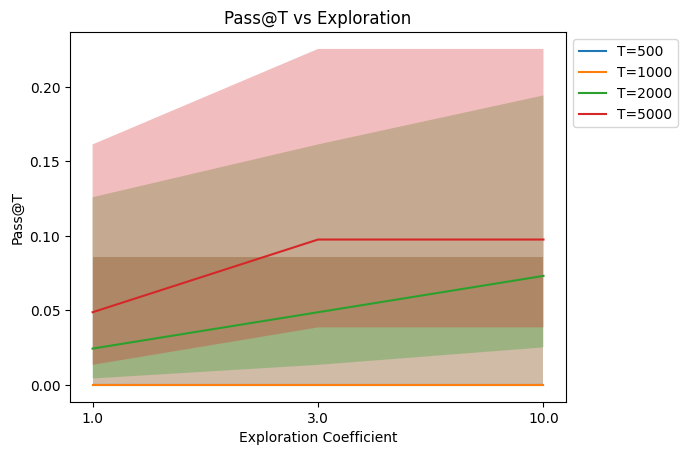

['1.0', '3.0', '10.0']


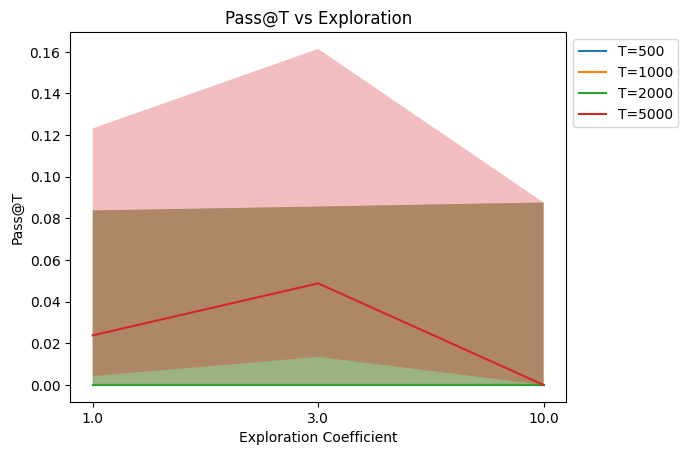

In [89]:
for temp in temps:
    discs = sorted([float(d) for d in df["discovery"].unique()])
    discs = [str(d) for d in discs]
    print(discs)


    for T in [500, 1000, 2000, 5000]:
        config_df = df[df["temp"] == temp]
        success_rates, lows, highs = [], [], []
        for discovery in discs:
            config_df_2 = config_df[config_df["discovery"] == discovery]
            if config_df_2.empty:
                success_rate, low, high = np.nan, np.nan, np.nan
            else:
                success_rate, low, high = compute_pass_at_t_and_ci(config_df_2, T)
            success_rates.append(success_rate)
            lows.append(low)
            highs.append(high)

        plt.plot(discs, success_rates, label=f"T={T}")
        plt.fill_between(discs, lows, highs, alpha=0.3)

    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.xlabel("Exploration Coefficient")
    plt.ylabel(f"Pass@T")
    plt.title(f"Pass@T vs Exploration")
    plt.show()